In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-fine-food-reviews/hashes.txt
/kaggle/input/amazon-fine-food-reviews/Reviews.csv
/kaggle/input/amazon-fine-food-reviews/database.sqlite


In this notebook, we will be doing sentiment analysis in Python using 2 techniques :- 
1. VADER (Valence Aware Dictionary and Sentiment Reasoner) - Bag of Words approach
2. Roberta pre - trained model from HuggingFace
3. HuggingFace Pipelines

# 0. Reading Data and NLTK basics

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [3]:
# Reading the data 
df = pd.read_csv('/kaggle/input/amazon-fine-food-reviews/Reviews.csv')

In [4]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
df.shape

(568454, 10)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [7]:
df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


# EDA

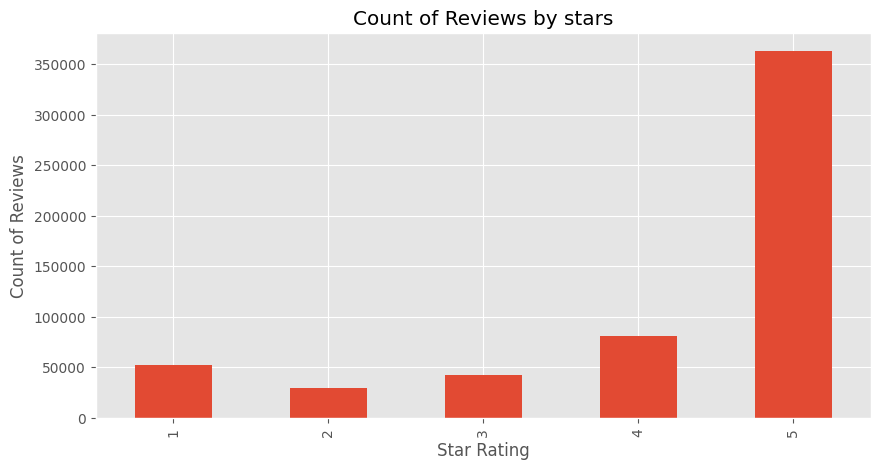

In [8]:
ax = df['Score'].value_counts().sort_index().plot(kind='bar',
                                                               title='Count of Reviews by stars',
                                                              figsize=(10, 5))
plt.xlabel('Star Rating')
plt.ylabel('Count of Reviews')
plt.show()

# NLTK

In [9]:
example = df['Text'][100]
print(example)

The mouth says, "How do I love thee, let me count the ways..."<br />If you like apple products a must have item.  The only draw back, shipping cost.  These are very heavy.


In [10]:
tokens = nltk.word_tokenize(example)

In [11]:
tokens

['The',
 'mouth',
 'says',
 ',',
 '``',
 'How',
 'do',
 'I',
 'love',
 'thee',
 ',',
 'let',
 'me',
 'count',
 'the',
 'ways',
 '...',
 "''",
 '<',
 'br',
 '/',
 '>',
 'If',
 'you',
 'like',
 'apple',
 'products',
 'a',
 'must',
 'have',
 'item',
 '.',
 'The',
 'only',
 'draw',
 'back',
 ',',
 'shipping',
 'cost',
 '.',
 'These',
 'are',
 'very',
 'heavy',
 '.']

In [12]:
tagged = nltk.pos_tag(tokens)

In [13]:
tagged

[('The', 'DT'),
 ('mouth', 'NN'),
 ('says', 'VBZ'),
 (',', ','),
 ('``', '``'),
 ('How', 'WRB'),
 ('do', 'VB'),
 ('I', 'PRP'),
 ('love', 'VB'),
 ('thee', 'NN'),
 (',', ','),
 ('let', 'VB'),
 ('me', 'PRP'),
 ('count', 'VB'),
 ('the', 'DT'),
 ('ways', 'NNS'),
 ('...', ':'),
 ("''", "''"),
 ('<', 'VBZ'),
 ('br', 'NN'),
 ('/', 'NNP'),
 ('>', 'NNP'),
 ('If', 'IN'),
 ('you', 'PRP'),
 ('like', 'VBP'),
 ('apple', 'NN'),
 ('products', 'NNS'),
 ('a', 'DT'),
 ('must', 'MD'),
 ('have', 'VB'),
 ('item', 'NN'),
 ('.', '.'),
 ('The', 'DT'),
 ('only', 'JJ'),
 ('draw', 'NN'),
 ('back', 'RB'),
 (',', ','),
 ('shipping', 'VBG'),
 ('cost', 'NN'),
 ('.', '.'),
 ('These', 'DT'),
 ('are', 'VBP'),
 ('very', 'RB'),
 ('heavy', 'JJ'),
 ('.', '.')]

In [14]:
for word, tag in tagged:
    description = nltk.help.upenn_tagset(tag)
    print(f"{word}: {tag} - {description}")

DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
The: DT - None
NN: noun, common, singular or mass
    common-carrier cabbage knuckle-duster Casino afghan shed thermostat
    investment slide humour falloff slick wind hyena override subhumanity
    machinist ...
mouth: NN - None
VBZ: verb, present tense, 3rd person singular
    bases reconstructs marks mixes displeases seals carps weaves snatches
    slumps stretches authorizes smolders pictures emerges stockpiles
    seduces fizzes uses bolsters slaps speaks pleads ...
says: VBZ - None
,: comma
    ,
,: , - None
``: opening quotation mark
    ` ``
``: `` - None
WRB: Wh-adverb
    how however whence whenever where whereby whereever wherein whereof why
How: WRB - None
VB: verb, base form
    ask assemble assess assign assume atone attention avoid bake balkanize
    bank begin behold believe bend benefit bevel beware bless boil bomb
    boost b

In [15]:
entities = nltk.chunk.ne_chunk(tagged)

In [16]:
entities.pprint()

(S
  The/DT
  mouth/NN
  says/VBZ
  ,/,
  ``/``
  How/WRB
  do/VB
  I/PRP
  love/VB
  thee/NN
  ,/,
  let/VB
  me/PRP
  count/VB
  the/DT
  ways/NNS
  .../:
  ''/''
  </VBZ
  br/NN
  //NNP
  >/NNP
  If/IN
  you/PRP
  like/VBP
  apple/NN
  products/NNS
  a/DT
  must/MD
  have/VB
  item/NN
  ./.
  The/DT
  only/JJ
  draw/NN
  back/RB
  ,/,
  shipping/VBG
  cost/NN
  ./.
  These/DT
  are/VBP
  very/RB
  heavy/JJ
  ./.)


# VADER sentiment scoring
We will use NLTK's **SentimentIntensityAnalyzer** to get the negative/neutral/positive scores of the text.
It uses a Bag of words approach :- 
1. Stop words are removed
2. Each word is scored and combined to a total score

In [17]:
!pip3 install twython

In [18]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [19]:
sia

In [20]:
example

'The mouth says, "How do I love thee, let me count the ways..."<br />If you like apple products a must have item.  The only draw back, shipping cost.  These are very heavy.'

In [21]:
sia.polarity_scores(example)

{'neg': 0.0, 'neu': 0.807, 'pos': 0.193, 'compound': 0.7717}

In [22]:
# Getting the polarity scores for the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/568454 [00:00<?, ?it/s]

In [23]:
vaders = pd.DataFrame(res).T

In [24]:
vaders = vaders.reset_index().rename(columns = {'index':'Id'})
vaders = vaders.merge(df, how='right')

In [25]:
vaders

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.079,0.853,0.068,-0.1027,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568449,568450,0.072,0.600,0.327,0.8589,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
568450,568451,0.190,0.697,0.114,-0.4848,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
568451,568452,0.037,0.884,0.078,0.4352,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
568452,568453,0.041,0.506,0.452,0.9717,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...


# Plotting VADER scores

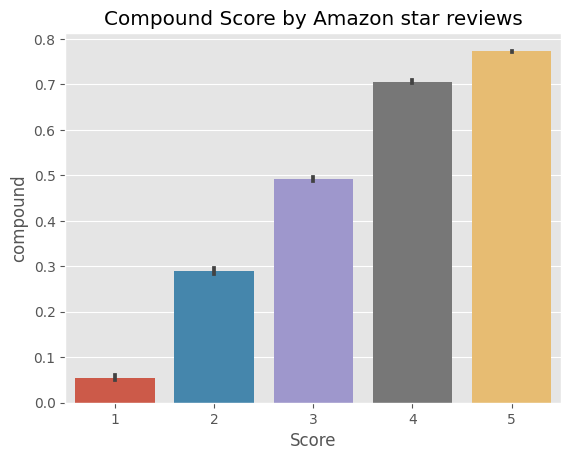

In [26]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title("Compound Score by Amazon star reviews")
plt.show()

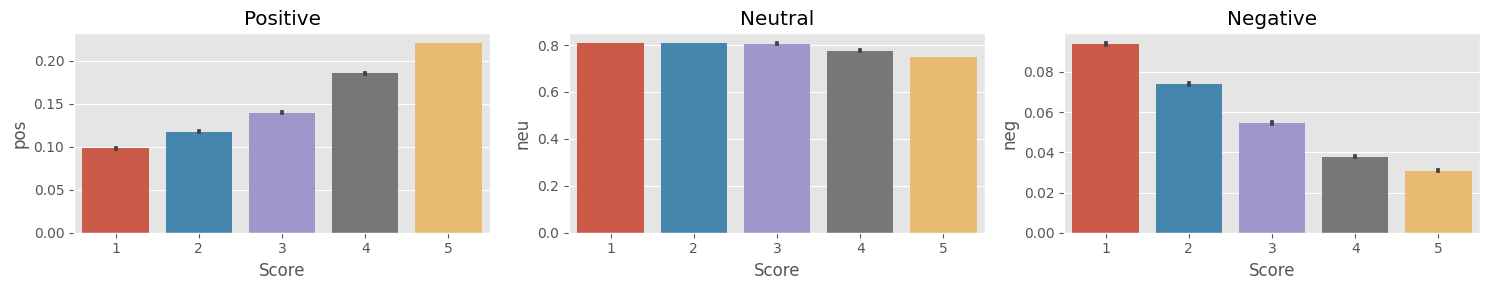

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(15, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=ax[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=ax[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=ax[2])
ax[0].set_title('Positive')
ax[1].set_title('Neutral')
ax[2].set_title('Negative')
plt.tight_layout()
plt.show()

# Roberta Pretrained Model
- Transformers model that not only accounts for the words but also the context related to other words

In [28]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [29]:
model = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model)
model = AutoModelForSequenceClassification.from_pretrained(model)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [30]:
# VADER results on example
print(example)
sia.polarity_scores(example)

The mouth says, "How do I love thee, let me count the ways..."<br />If you like apple products a must have item.  The only draw back, shipping cost.  These are very heavy.


{'neg': 0.0, 'neu': 0.807, 'pos': 0.193, 'compound': 0.7717}

In [32]:
# Run for Roberta model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.30692074, 'roberta_neu': 0.45656884, 'roberta_pos': 0.23651049}


In [35]:
def polarity_scores_from_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [38]:
# Getting the polarity scores for the entire dataset
df = df.head(3000)
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_from_roberta(text)

        combined_result = {**vader_result_rename, **roberta_result}
        res[myid] = combined_result
        
    except RuntimeError:
        print(f"Broke for id {myid}")

  0%|          | 0/3000 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187
Broke for id 529
Broke for id 540
Broke for id 746
Broke for id 863
Broke for id 1053
Broke for id 1070
Broke for id 1156
Broke for id 1321
Broke for id 1375
Broke for id 1498
Broke for id 1575
Broke for id 1796
Broke for id 1826
Broke for id 2169
Broke for id 2248
Broke for id 2476
Broke for id 2492
Broke for id 2584
Broke for id 2610
Broke for id 2897
Broke for id 2898
Broke for id 2902
Broke for id 2928
Broke for id 2942
Broke for id 2944
Broke for id 2947
Broke for id 2948


In [39]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns = {'index':'Id'})
results_df = results_df.merge(df, how='right')

In [41]:
results_df

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.079,0.853,0.068,-0.1027,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2996,0.104,0.767,0.129,0.6764,0.018536,0.143635,0.837830,B0009JI7O8,A3KLEQQVY1I46S,Spence,2,2,4,1344297600,Color Discrepancy,"My primary reason for ordering, was the pictur..."
2996,2997,0.000,0.849,0.151,0.6705,0.009140,0.132566,0.858294,B0009JI7O8,A1WXEIP21U01ME,zazza,4,5,5,1297900800,crispy fresh,The cookie is crispy good and flavorful. The ...
2997,2998,0.231,0.769,0.000,-0.9610,0.950696,0.042820,0.006484,B0009JI7O8,A7XPFLQYVPZAT,Kim Voong,1,1,2,1334361600,they are soooo tiny!,I was expecting these cookies were going to be...
2998,2999,0.035,0.810,0.155,0.8655,0.006778,0.060676,0.932546,B0009JI7O8,A3ADANTR6G4LPB,Marjory Warrington,1,1,5,1323129600,Excellent service and product,I ordered these fortune cookies as rewards for...


# Compare scores of the 2 models

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

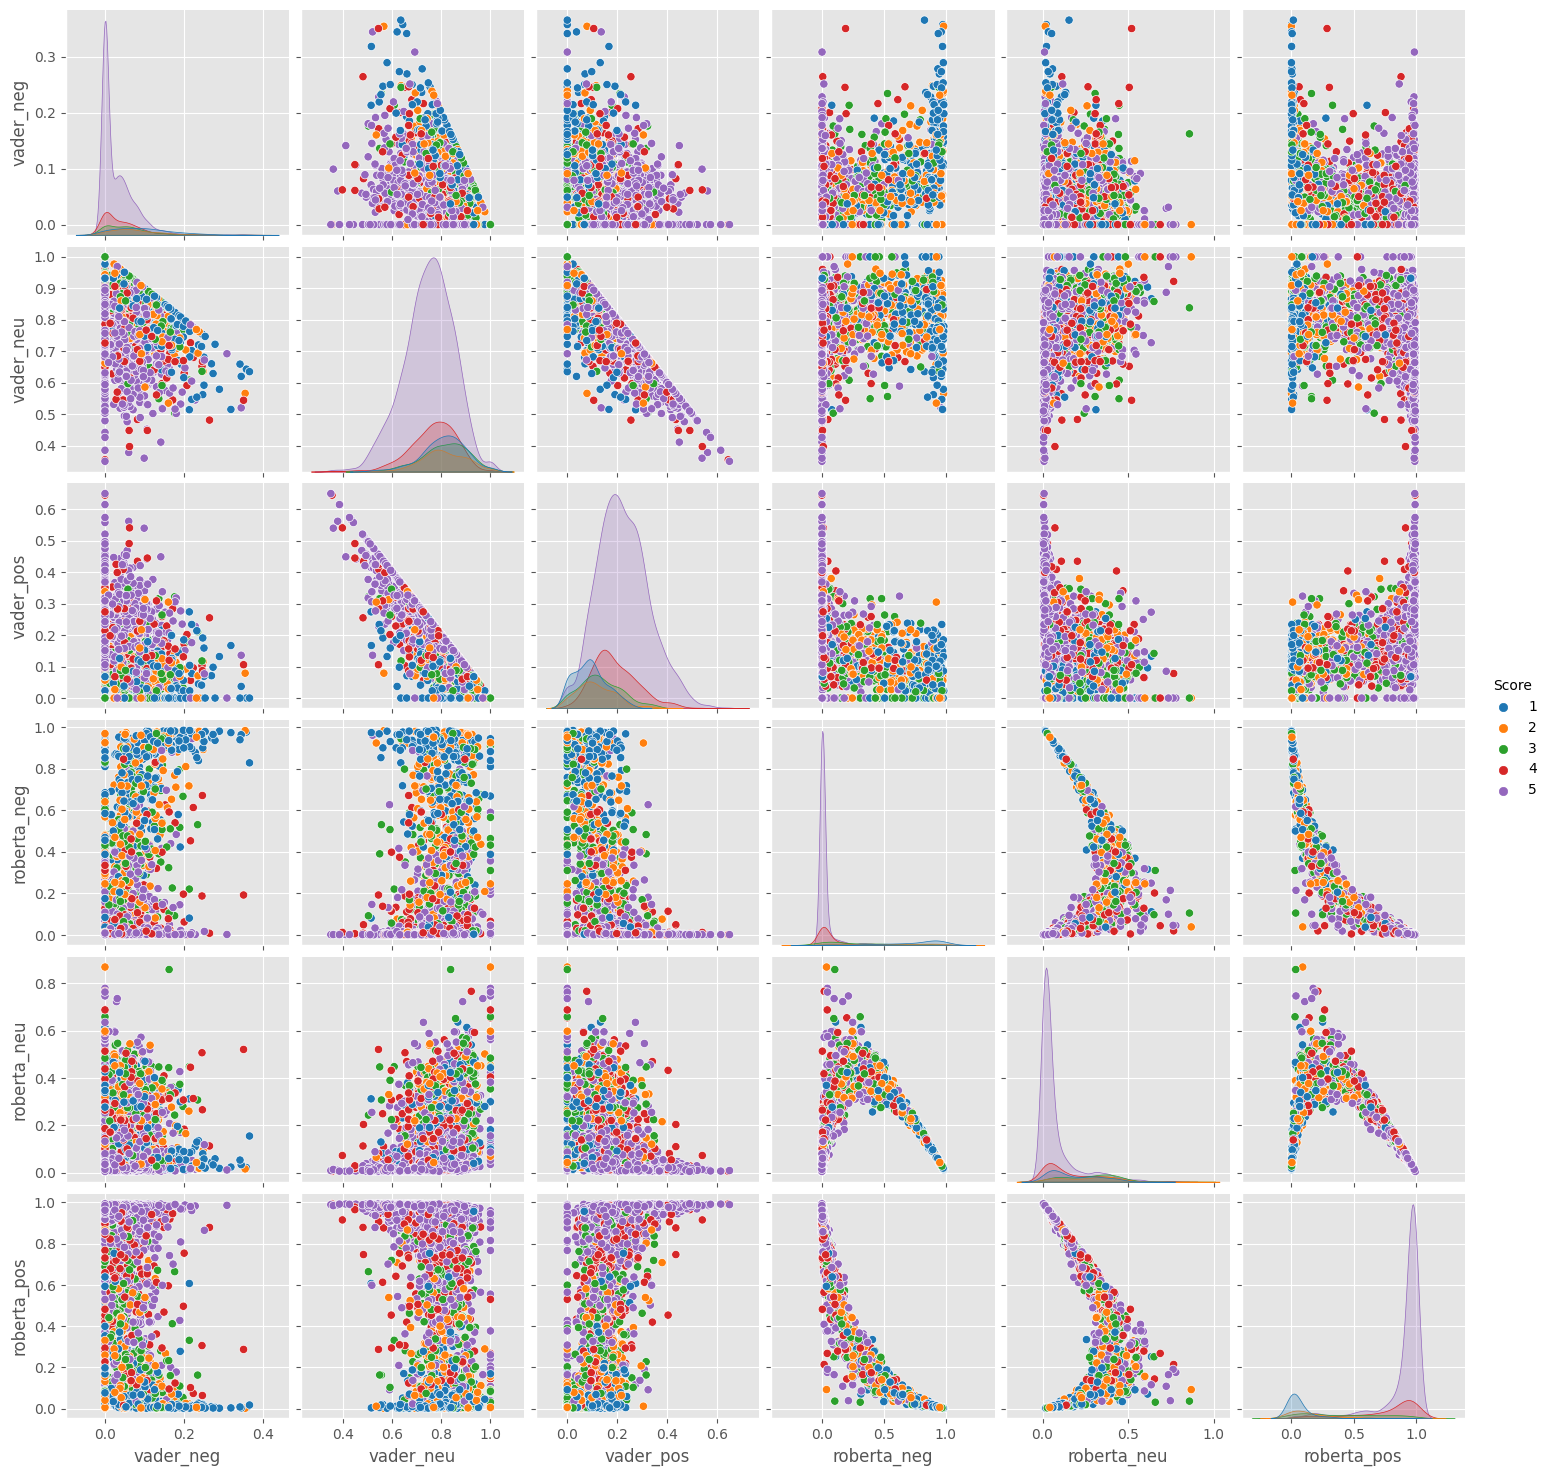

In [40]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Score',
            palette='tab10')
plt.show()

# Review examples

- Positive 1-star and negative 5-star reviews

In [43]:
results_df.query('Score == 1').sort_values('roberta_pos', ascending=False)['Text'].values[0]

'I got two Teas and one type of iced coffe and the rest were HOLIDAY COFFEES and APPLE CIDER!  Spicy Eggnog? Gingerbread? Bait and swtich.  The only redeeming factor - Amazon was great and issued me a refund.'

In [44]:
results_df.query('Score == 1').sort_values('vader_pos', ascending=False)['Text'].values[0]

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

In [45]:
results_df.query('Score == 5').sort_values('roberta_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [46]:
results_df.query('Score == 5').sort_values('vader_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

# Using the Transformers pipeline

In [47]:
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis")

2024-06-27 13:59:00.048218: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-27 13:59:00.048320: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-27 13:59:00.183240: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_downloa

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [48]:
print(example)

The mouth says, "How do I love thee, let me count the ways..."<br />If you like apple products a must have item.  The only draw back, shipping cost.  These are very heavy.


In [49]:
sentiment_pipeline(example)

[{'label': 'NEGATIVE', 'score': 0.9944590330123901}]